**Used some code from this amazing notebook** [ https://www.kaggle.com/marto24/bankruptcy-detection ]

# Importing Libraries

In [1]:
#basic lib
import pandas as pd
import numpy as np 
import math,os,random

#EDA
import matplotlib.pyplot as plt 
import seaborn as sns
# import pandas_profiling as pf

#oversampling:
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN,SMOTETomek

#preprocessing:
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.decomposition import PCA

#model_selection
# from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline


#ml algo
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LassoLars
from xgboost import XGBClassifier 
from catboost import CatBoostClassifier
# from sklearn.cluster import KMeans

#scoring function:
from sklearn.metrics import make_scorer,f1_score,confusion_matrix,ConfusionMatrixDisplay

**Setting random state for reproducibility**

In [2]:
def set_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    
seed=5
set_seed(seed)

# Loading Data and EDA

In [3]:
df=pd.read_csv('../input/company-bankruptcy-prediction/data.csv')
df.head()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474
3,1,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490


**Checking for null and categorical values **

In [4]:
#no empty values in data .

# cols_to_be_imputed=[col for col in df.columns if df[col].isnull().sum()>0]
# cols_to_be_imputed

#categorical cols:
# categ_cols=[col for col in df.columns if df[col].dtype in ['object'] ]
# categ_cols

#profile report:
# pf.ProfileReport(df,minimal=True)

**Class Balance**

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


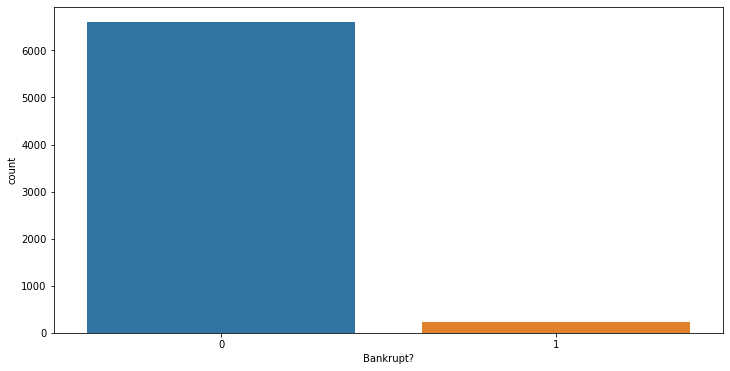

In [5]:
def plot_class_balance(df,target):
    plt.figure(figsize=(12,6))
    sns.countplot(df[target])
    plt.show()
    
plot_class_balance(df,'Bankrupt?')

This illustrates that there is a heavy imbalance between companies going bankrupt and not going bankrupt.

**Correlation HeatMap**

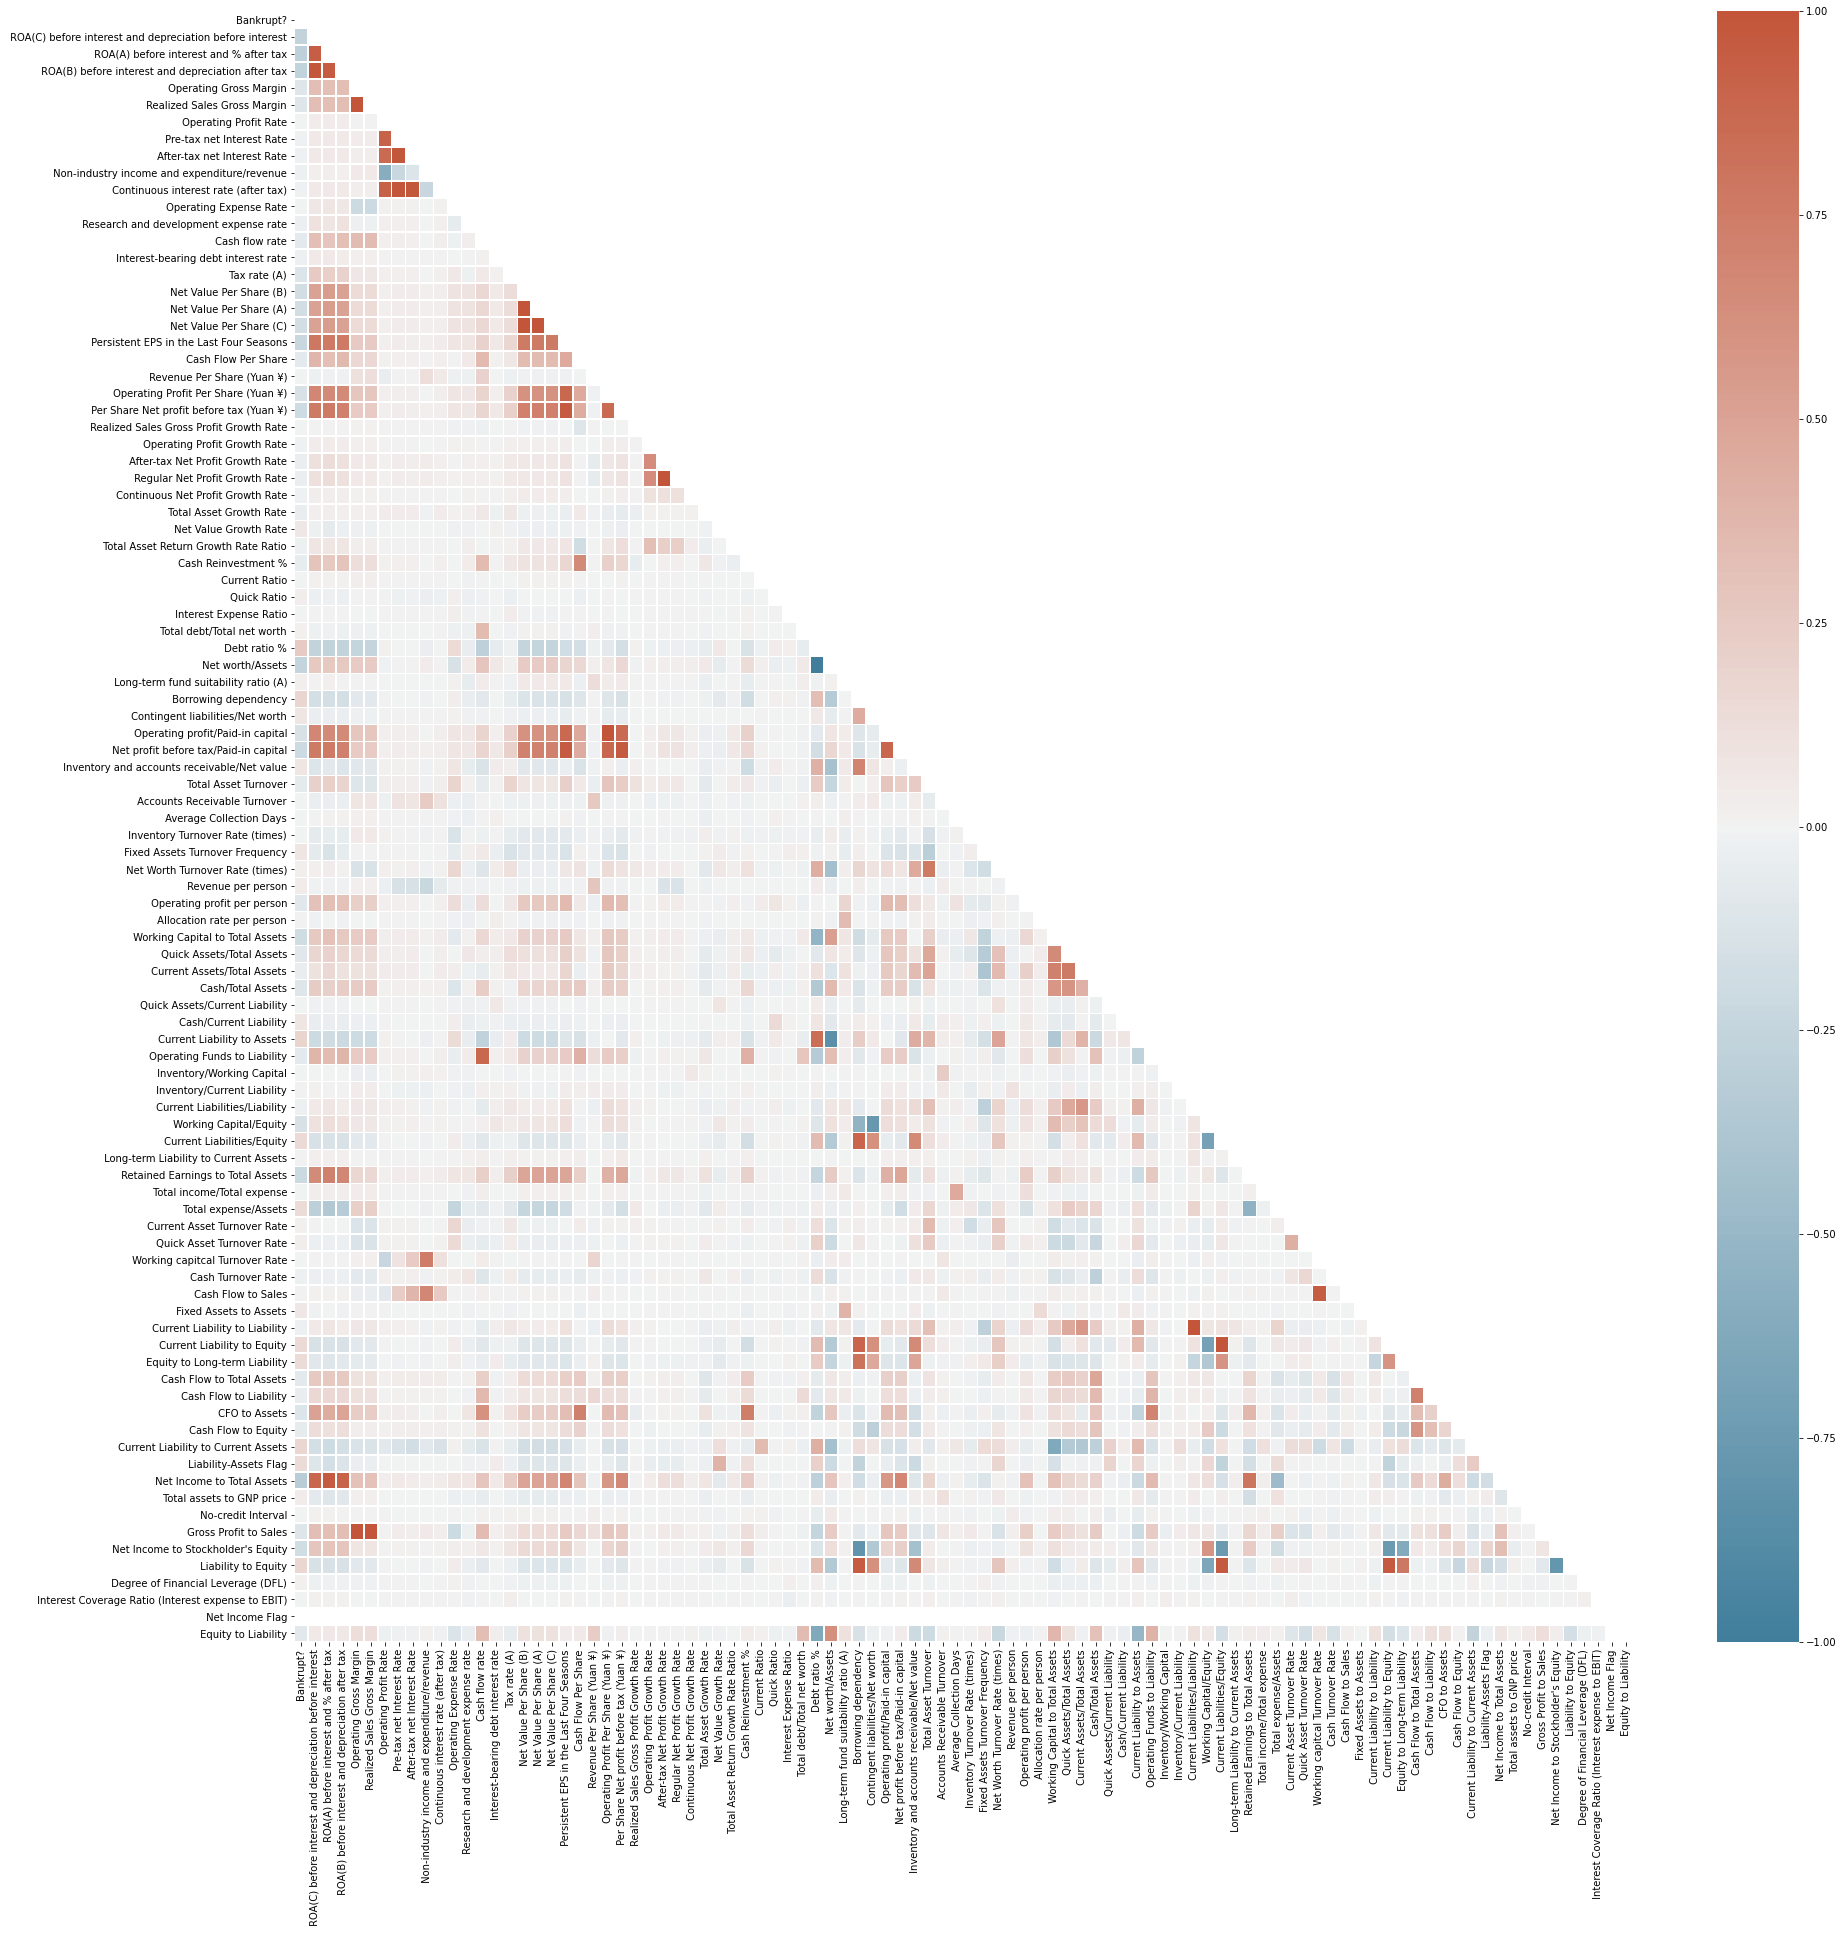

In [6]:
def plot_correlation(df):
    plt.figure(figsize=(30,30))
    corr=df.corr()
    mask=np.triu(np.ones_like(corr,dtype=bool))
    sns.heatmap(corr,mask=mask,cmap=sns.diverging_palette(230, 20, as_cmap=True),
               linewidth=0.5)
    plt.show()
    
plot_correlation(df)

**Plotting Boxplots**

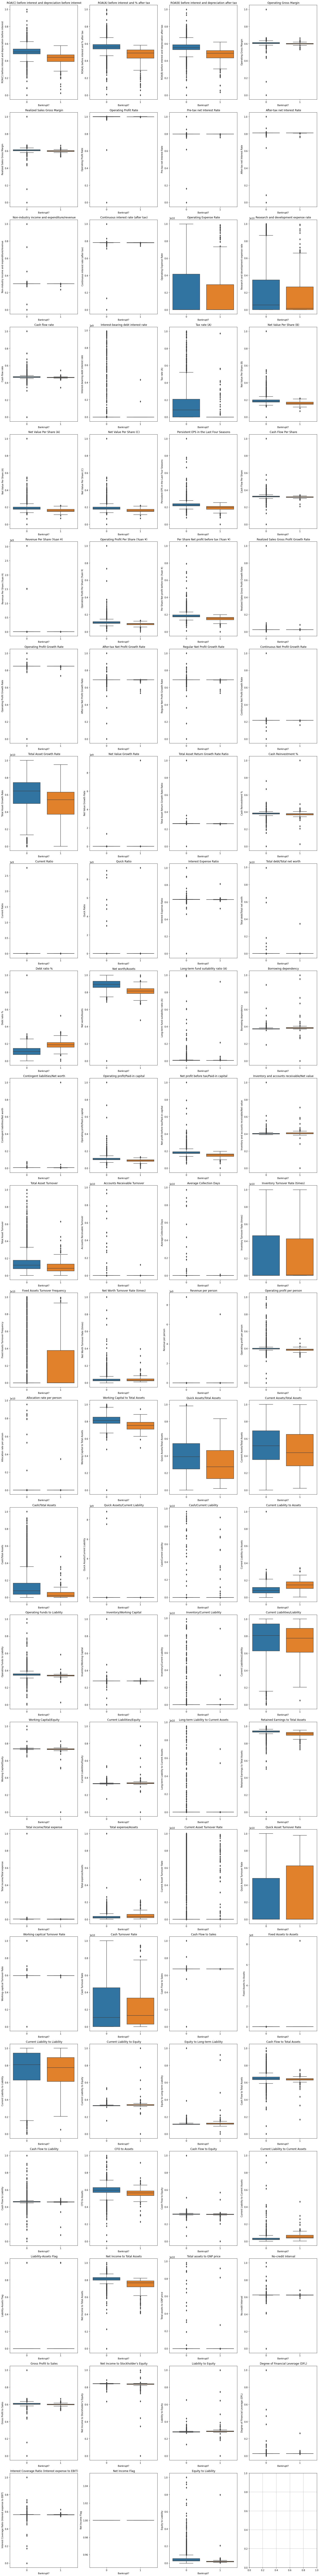

In [7]:
def plot_boxplots(df):
    n=len(df.columns)
    plt.subplots(math.ceil(n/4),4,figsize=(20,8*math.ceil(n/5)))
    plt.grid('off')
    
    for i,col in enumerate(df.drop('Bankrupt?',axis=1).columns):
        plt.subplot(math.ceil(n/4),4,i+1)
        
        sns.boxplot(x='Bankrupt?',y=col,data=df)
        plt.title(f'{col}')
        
    plt.tight_layout()
    plt.show()
plot_boxplots(df)        

**Specify Outliers**
* Adding a extra feature that specifies a outlier and assigns a value +1 to the feature 'Is_Outlier' if its an outlier.

**Formulas**:

* **IQR(Inter Quartile Range) = Q3-Q1**
* **lower limit = Q1 - (1.5 * IQR)**
* **upper limit= Q3 + (1.5 * IQR)**

In [8]:


def specify_outliers(df):    
    df_new=df.copy()
    df_new['Is_Outlier']=np.zeros(len(df_new))

    for col in df.drop('Bankrupt?',axis=1).columns:
                
        
        Q1=np.percentile(df[col],25)
        Q3=np.percentile(df[col],75)
        
        col_IQR = Q3-Q1
        
        lower_limit= Q1 - (1.5 * col_IQR)
        upper_limit= Q3 + (1.5 * col_IQR)
        
        outliers_idx=[i for i,x in enumerate(df[col]) if x<lower_limit or x> upper_limit]
        
        for i in outliers_idx:
            df_new['Is_Outlier'].iloc[i] +=1
        
        #replacing outliers with median
#         median= np.median(df[col])
#         df_new[col].replace(to_replace=outliers,value=median,inplace=True)
        
    return df_new

new_df=specify_outliers(df)        

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1636: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


**Adding new features and Train Test Split**

In [9]:
y=new_df.pop('Bankrupt?')
X=new_df.copy()


# adding new features using PCA
pca_pipe= Pipeline([('Scale',StandardScaler()),('PCA',PCA(n_components=10))])

X_pca=pca_pipe.fit_transform(X)
X_pca=pd.DataFrame(X_pca,columns=[f'P{i}' for i in range(1,X_pca.shape[1]+1)])
X=X.join(X_pca)

In [10]:
X_train,X_val,y_train,y_val=train_test_split(X,y,shuffle=True,random_state=seed)

# Scoring a model without upsampling.

**Building a scoring function**

Because of there is class imbalance in the data , accuracy will perform poorly as a metric. We will use f1_score as metric, which is the harmonic mean of precision and recall.  

**Constructing models**

In [11]:
# Learning pipelines:
#logistic reg:
# log_pipe=Pipeline([(('Normalize'),MinMaxScaler()),('LassoLars',LassoLars(verbose=0))])

#RandomForest
RF_pipe=Pipeline([('Random_forest',RandomForestClassifier(n_estimators=300,random_state=seed,verbose=0))])

#XGBClassifier
XGB_pipe=Pipeline([('Normalize',MinMaxScaler()),('XGB',XGBClassifier(n_estimators=300,random_state=seed,use_label_encoder =False,
                                                                     objective ='binary:logistic',verbosity=0))])

#catboost classifier
catb_pipe=Pipeline([('Normalize',MinMaxScaler()),('Catboost',CatBoostClassifier(n_estimators=300,
                                                                                random_state=seed,verbose=0))])

pipes=[RF_pipe,XGB_pipe,catb_pipe]

In [12]:
for pipe in pipes:
    pipe.fit(X_train,y_train)
    pred=pipe.predict(X_val)
    f1=f1_score(pred,y_val)
    print(f'f1 Score with {pipe} is {f1}')

f1 Score with Pipeline(steps=[('Random_forest',
                 RandomForestClassifier(n_estimators=300, random_state=5))]) is 0.3466666666666667
f1 Score with Pipeline(steps=[('Normalize', MinMaxScaler()),
                ('XGB',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=300,
                               n_jobs=4, num_parallel_tree=1, random_state=5,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               subsample=1, tree_method='exac

# Oversampling and Combine methods for Class imbalance.

In [13]:
#oversampling minority
smote=SMOTE()

#smote +ENN 
smote_enn=SMOTEENN()

#Smote + Tomek:
smote_tomek=SMOTETomek()


def resample(function,X,y):
    x_r,y_r= function.fit_resample(X,y)
    return x_r,y_r

**Oversampling using smote**

In [14]:
x_new,y_new=resample(smote,X_train,y_train)

for pipe in pipes:
    pipe.fit(x_new,y_new)
    pred=pipe.predict(X_val)
    f1=f1_score(pred,y_val)
    print(f'f1 Score with {pipe} is {f1}')

del x_new,y_new


f1 Score with Pipeline(steps=[('Random_forest',
                 RandomForestClassifier(n_estimators=300, random_state=5))]) is 0.460431654676259
f1 Score with Pipeline(steps=[('Normalize', MinMaxScaler()),
                ('XGB',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=300,
                               n_jobs=4, num_parallel_tree=1, random_state=5,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               subsample=1, tree_method='exact

**SMOTE + ENN**

In [15]:
x_new,y_new=resample(smote_enn,X_train,y_train)

for pipe in pipes:
    pipe.fit(x_new,y_new)
    pred=pipe.predict(X_val)
    f1=f1_score(pred,y_val)
    print(f'f1 Score with {pipe} is {f1}')

del x_new,y_new


f1 Score with Pipeline(steps=[('Random_forest',
                 RandomForestClassifier(n_estimators=300, random_state=5))]) is 0.422360248447205
f1 Score with Pipeline(steps=[('Normalize', MinMaxScaler()),
                ('XGB',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=300,
                               n_jobs=4, num_parallel_tree=1, random_state=5,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               subsample=1, tree_method='exact

**SMOTE + Tomek**

In [16]:
x_new,y_new=resample(smote_tomek,X_train,y_train)

for pipe in pipes:
    pipe.fit(x_new,y_new)
    pred=pipe.predict(X_val)
    f1=f1_score(pred,y_val)
    print(f'f1 Score with {pipe} is {f1}')

del x_new,y_new


f1 Score with Pipeline(steps=[('Random_forest',
                 RandomForestClassifier(n_estimators=300, random_state=5))]) is 0.4366197183098592
f1 Score with Pipeline(steps=[('Normalize', MinMaxScaler()),
                ('XGB',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=300,
                               n_jobs=4, num_parallel_tree=1, random_state=5,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               subsample=1, tree_method='exac

# Predictions

In [17]:
def predict(X_t,y_t,X_test):
    #resampling using smote+tomek
    x_st,y_st =resample(smote_tomek,X_t,y_t)
    
    #Kfold cross validation:
    kf=KFold(n_splits=5,random_state=seed,shuffle=True)
    
    #predicting using smote and XGB Classifier:
    
    preds_xgb=[]
    preds_catb=[]
    preds_rf=[]

    for train_idx,test_idx in kf.split(x_st,y_st):
        X_tr,X_ts = x_st.iloc[train_idx],x_st.iloc[test_idx]
        y_tr,y_ts = y_st.iloc[train_idx],y_st.iloc[test_idx]
        
        #fitting data on models:
        #Catboost
        catb_pipe.fit(X_tr,y_tr)
        
        #XGB Classifier
        XGB_pipe.fit(X_tr,y_tr)
        #RF Classifier
        RF_pipe.fit(X_tr,y_tr)
        
        
        #predicting on test set:
        preds_catb.append(XGB_pipe.predict(X_test))
        #predicting on test set:
        preds_xgb.append(XGB_pipe.predict(X_test))
       
        #predicting on test set:
        preds_rf.append(RF_pipe.predict(X_test))
        
        
        
    
    #Averaging Both prediction:
    mean_preds= (np.array(preds_xgb)/3 + np.array(preds_catb)/3 + np.array(preds_rf)/3)
    
    #averaging predictions across all folds:
    preds=np.mean(a=mean_preds,axis=0)
    
    assert len(preds)== len(X_test)
    
    del mean_preds,preds_xgb,preds_catb
    
    return preds


## Predicting Boolean value based on threshold:
def assign_bool_values(preds,thresh=0.5):
    final_preds=[]
    
    for i in preds:
        if i> thresh:
            final_preds.append(1)
        else:
            final_preds.append(0)
            
    assert(len(final_preds)==len(preds))
    
    
    return final_preds
    

In [18]:
pred=predict(X_t=X_train,y_t=y_train,X_test=X_val)
pred.mean()

0.04727272727272727

**Using the function 'assign_bool_values', we can play with threshold values for predictions.**

In [19]:
predictions=assign_bool_values(preds=pred,thresh=0.2)
f1_score(predictions,y_val)

0.4727272727272727

**Confusion Matrix**

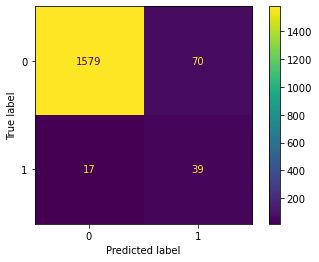

In [20]:

def display_cm(pred,y_test):
    
    cm=confusion_matrix(y_test,pred)
    
    disp=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['0','1'])
    
    disp.plot()
    plt.show()

display_cm(predictions,y_val)

**I have kept the threshold low , so that maximum of bankruptcy cases are identified. This results in a relatively low f1_score , as the ensemble incorrectly predicts some false positives. I would probably get better f1_score if I try to find optimum threshold and use SMOTE for resampling.**